In [211]:
import numpy as np
from typing import Dict, Tuple, Set, List
from copy import deepcopy
from math import sin,cos,pi, tan, sqrt
from itertools import product
import matplotlib.pyplot as plt

### Hybrid A* for Dubins Car Model
| Ref: https://github.com/jhan15/dubins_path_planning



In [212]:
class Conflict:
    """ Conflict area defined by its center. """
    def __init__(self, x, y, radius=1.0):
        self.x = float(x)
        self.y = float(y)
        self.radius = float(radius)

    def point_safe(self, pt):
        """ Check if a point is safe from the obstacle. """
        px, py = pt
        return sqrt((px - self.x)**2 + (py - self.y)**2) > self.radius

    # def circle_safe(self, cx, cy, r):
    #     """ Check if a circle is safe from the obstacle. """
    #     return sqrt((cx - self.x)**2 + (cy - self.y)**2) > (self.radius + r)

In [213]:
class Environment:
    """ The map configuration. """

    def __init__(self, conflicts=None, lx=20, ly=10):
        self.lx = float(lx)
        self.ly = float(ly)

        if conflicts:
            self.conflicts = [Conflict(*conflict) for conflict in conflicts]
        else:
            self.conflicts = []

    def is_point_safe(self, pt):
        """ Check if a point is safe from all conflict areas. """
        for conflict in self.conflicts:
            if not conflict.point_safe(pt):
                return False
        return True

In [214]:
class DubinsCar:
    def __init__(self, env: Environment, start_pos=None, end_pos=None):
      self.env = env
      self.start_pos = start_pos
      self.end_pos = end_pos

    def step(self, pos, w, dt=1e-2):
        """ Car dynamics with fixed linear velocity v = 1 and angular velocity w. """
        x, y, theta = pos
        v = 1  # fixed linear velocity
        x += v * cos(theta) * dt
        y += v * sin(theta) * dt
        theta += w * dt
        if(theta > pi):
            theta -= 2*pi
        if(theta < -pi):
            theta += 2*pi

        return [x, y, theta]

    def is_pos_safe(self, pos):
        """ Check position safety. For simplicity, assume point safety check. """
        x, y, _ = pos
        return 0 <= x <= self.env.lx and 0 <= y <= self.env.ly and self.env.is_point_safe((x, y))

    def get_path(self, start_pos, route):
        """ Generate path according to route. """

        path = []
        pos = start_pos

        for w, steps in route:
            for _ in range(steps):
                pos = self.step(pos, w)
                path.append(pos)
        return path

In [215]:
class Grid:
    """ Grid configuration. """

    def __init__(self, env, cell_size=0.25):
        self.env = env
        self.cell_size = cell_size

        self.n = int(self.env.lx / self.cell_size)
        self.m = int(self.env.ly / self.cell_size)

        self.cell_dia = sqrt(2 * self.cell_size ** 2)

        self.get_conflict_occupancy()

    def get_conflict_occupancy(self):
        """ Fill grid with conflict areas. """
        self.grid = [[0] * self.m for _ in range(self.n)]

        for conflict in self.env.conflicts:
            x1, y1 = self.to_cell_id([conflict.x - conflict.radius, conflict.y - conflict.radius])
            x2, y2 = self.to_cell_id([conflict.x + conflict.radius, conflict.y + conflict.radius])

            for i in range(x1, x2 + 1):
                for j in range(y1, y2 + 1):
                    if self.is_point_in_conflict(i * self.cell_size, j * self.cell_size, conflict):
                        self.grid[i][j] = 1

    def is_point_in_conflict(self, x, y, conflict):
        """ Check if a point is within a conflict area. """
        return sqrt((x - conflict.x) ** 2 + (y - conflict.y) ** 2) <= conflict.radius

    def to_cell_id(self, pt):
        """ Convert point into grid index. """
        x = min(int(pt[0] / self.cell_size), self.n - 1)
        y = min(int(pt[1] / self.cell_size), self.m - 1)
        return [x, y]

    # def get_neighbors(self, cell_id):
    #     """ Get all the 4 adjacent cells. """
    #     x, y = cell_id
    #     nbs = []

    #     for p in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
    #         if 0 <= x + p[0] < self.n and 0 <= y + p[1] < self.m:
    #             if self.grid[x + p[0]][y + p[1]] == 0:
    #                 nbs.append([x + p[0], y + p[1]])

    #     return nbs


In [216]:
def get_discretized_thetas(unit_theta):
    """ Get all discretized theta values by unit value. """

    thetas = [0]
    while True:
        theta = thetas[-1] + unit_theta
        if theta > (2*pi - unit_theta):
            break
        thetas.append(theta)

    return thetas

def theta_diff(theta1, theta2):
    return min(abs(theta1 - theta2), 2*pi - abs(theta1 - theta2))

def round_theta(theta, thetas):
    """ Round theta to closest discretized value. """
    return min(thetas, key=lambda x: abs(x-theta) % (2*pi))

def same_point(pt1, pt2, h=1e-2, dtheta = 1e-1):
    """ Check two points are same within a small distance and orientation error. """
    d = distance(pt1, pt2)
    return d < h and theta_diff(pt1[2], pt2[2]) < dtheta
    # return d < h

def distance(pt1, pt2):
    """ Distance of two points. """
    d = sqrt((pt1[0]-pt2[0])**2 + (pt1[1]-pt2[1])**2)

    return d

In [217]:
class Node:
    """ Hybrid A* tree node. """

    def __init__(self, grid_pos, pos):
        self.grid_pos = grid_pos
        self.pos = pos
        self.g = None
        self.g_ = None
        self.f = None
        self.parent = None
        self.w = 0
        self.branches = []

    def __eq__(self, other):
        return self.grid_pos == other.grid_pos

    def __hash__(self):
        return hash((self.grid_pos))

In [218]:
class HybridAstar:
    """ Hybrid A* search procedure. """

    def __init__(self, car, grid, unit_theta=pi/12, dt=1e-2, ws=[-1,-0.5,0,0.5,1]):
        self.car = car
        self.grid = grid
        self.unit_theta = unit_theta
        self.dt = dt

        self.start = self.car.start_pos
        self.goal = self.car.end_pos

        self.drive_steps = int(sqrt(2) * self.grid.cell_size / self.dt) + 1
        self.arc = self.drive_steps * self.dt
        # self.ws = [0,0.2,0.4,0.6,0.8,1]# range of angular velocities
        # self.ws = [-1,-0.5,0,0.5,1]
        self.ws = ws

        self.thetas = get_discretized_thetas(self.unit_theta)

    def construct_node(self, pos):
        """ Create node for a pos. """

        theta = pos[2]
        pt = pos[:2]

        theta = round_theta(theta % (2 * pi), self.thetas)

        cell_id = self.grid.to_cell_id(pt)
        grid_pos = cell_id + [theta]

        return Node(grid_pos, pos)

    def simple_heuristic(self, pos):
        """ Heuristic by Euclidean distance. """
        return abs(self.goal[0] - pos[0]) + abs(self.goal[1] - pos[1]) + 0.1*theta_diff(self.goal[2], pos[2])

    def get_children(self, node):
        """ Get successors from a state. """

        children = []
        for w in self.ws:
            pos = node.pos
            branch = [pos[:3]]

            for _ in range(self.drive_steps):
                pos = self.car.step(pos, w, self.dt)
                branch.append(pos[:3])

            if not self.car.is_pos_safe(pos):
                continue

            child = self.construct_node(pos)
            child.w = w
            child.parent = node
            child.g = node.g + self.arc
            child.g_ = node.g_ + self.arc
            child.f = child.g + self.simple_heuristic(child.pos)
            children.append([child, branch])

        return children

    def backtracking(self, node):
        """ Backtracking the path. """
        route = []
        while node.parent:
            route.append((node.w, self.drive_steps))
            node = node.parent
        return list(reversed(route))

    def search_path(self, min_goal_dist=1e-1,min_goal_dtheta=1e-1):
        """ Hybrid A* pathfinding. """
        root = self.construct_node(self.start)
        root.g = float(0)
        root.g_ = float(0)
        root.f = root.g + self.simple_heuristic(root.pos)
        closed_ = []
        open_ = [root]

        count = 0
        while open_:
            count += 1
            best = min(open_, key=lambda x: x.f)

            open_.remove(best)
            closed_.append(best)

            if same_point(best.pos[:3], self.goal[:3],min_goal_dist,min_goal_dtheta):
                route = self.backtracking(best)
                path = self.car.get_path(self.start, route)
                cost = best.g_
                print('Shortest path: {}'.format(round(cost, 2)))
                print('Total iterations:', count)
                return path, cost

            children = self.get_children(best)

            for child, branch in children:
                if child in closed_:
                    continue
                if child not in open_:
                    best.branches.append(branch)
                    open_.append(child)
                elif child.g < open_[open_.index(child)].g:
                    best.branches.append(branch)
                    c = open_[open_.index(child)]
                    p = c.parent
                    for b in p.branches:
                        if same_point(b[-1], c.pos[:3],min_goal_dist,min_goal_dtheta):
                            p.branches.remove(b)
                            break
                    open_.remove(child)
                    open_.append(child)

        return None, None

In [219]:
def single_car_hybrid_astar(env, start_pos, end_pos):
    # Create a simple car model
    car = DubinsCar(env, start_pos=start_pos, end_pos=end_pos)

    # Create a grid for the environment
    grid = Grid(env, cell_size=0.25) # 0.25

    # Initialize Hybrid A* with the car and grid
    # full_ws = [-1,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
    hybrid_astar = HybridAstar(car, grid, dt=1e-2) # 1e-2

    # Run the pathfinding algorithm
    path, cost = hybrid_astar.search_path(min_goal_dist=0.2,min_goal_dtheta=0.1) # 0.2 and 0.1

    # Extract positions from the path for plotting
    if path:
        path_positions = [(state[0], state[1], state[2]) for state in path]
        # for state in path:
        #     print(state)
        return path_positions, cost
    else:
        return False

In [220]:
def plot_single_car_path(ax, path=None):
    xs = [pos[0] for pos in path]
    ys = [pos[1] for pos in path]
    thetas = [pos[2] for pos in path]

    ax.plot(xs, ys, 'b-', linewidth=2)
    ax.plot(xs[0], ys[0], 'go')  # Start point
    dx = cos(thetas[-1]) * 0.5  # End Arrow
    dy = sin(thetas[-1]) * 0.5
    ax.arrow(xs[-1]-dx, ys[-1]-dy, dx, dy, head_width=0.2, head_length=0.2, fc='r', ec='r')
    # ax.arrow(xs[-1], ys[-1], 'ro')  # End point

    # Sample 10 points for plotting direction arrows
    sample_indices = list(range(0, len(path), max(1, len(path) // 100)))
    sampled_path = [path[i] for i in sample_indices]

    # Plot direction arrows at sampled points
    for x, y, theta in sampled_path:
        dx = cos(theta) * 0.5  # Arrow length
        dy = sin(theta) * 0.5
        ax.arrow(x, y, dx, dy, head_width=0.2, head_length=0.2, fc='k', ec='k')


In [222]:
start_pos = [2.0, 5.0, 0]
end_pos = [18.0, 5.0, -pi/2]
# conflicts = [[10,5,3]]
conflicts=None
env = Environment(conflicts=conflicts, lx=20, ly=10)
path, cost = single_car_hybrid_astar(env, start_pos, end_pos)
if not path:
    print("no path found")
else:
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_xlim(0, 20)
    ax.set_ylim(0, 10)
    ax.set_aspect('equal')
    plot_single_car_path(ax, path)
    for conflict in env.conflicts:
        ax.add_patch(plt.Circle((conflict.x, conflict.y), conflict.radius, fill=True, color='r', alpha=0.5))

KeyboardInterrupt: 

## Collision-Based Search (CBS)

---



In [223]:
def multi_car_hybrid_astar(conflicts=None):
    path_1,cost_1 = single_car_hybrid_astar(Environment(conflicts=[[10,3.5,2]], lx=20, ly=10), [0.0, 0.0, 0], [20.0, 10.0, 0])
    path_2,cost_2 = single_car_hybrid_astar(Environment(conflicts=[], lx=20, ly=10), [0.0, 10.0, 0], [20.0, 0.0, 0])
    path_3,cost_3 = single_car_hybrid_astar(Environment(conflicts=[], lx=20, ly=10), [20.0, 0.0, -pi], [0.0, 10.0, -pi])
    path_4,cost_4 = single_car_hybrid_astar(Environment(conflicts=[[10,6.5,2]], lx=20, ly=10), [20.0, 10.0, -pi], [0.0, 0.0, -pi])
    return [path_1, path_2, path_3, path_4], cost_1+cost_2+cost_3+cost_4

[path_1, path_2, path_3, path_4], total_cost = multi_car_hybrid_astar()

Shortest path: 23.04
Total iterations: 120
Shortest path: 23.4
Total iterations: 488
Shortest path: 23.4
Total iterations: 489
Shortest path: 23.04
Total iterations: 126


[]

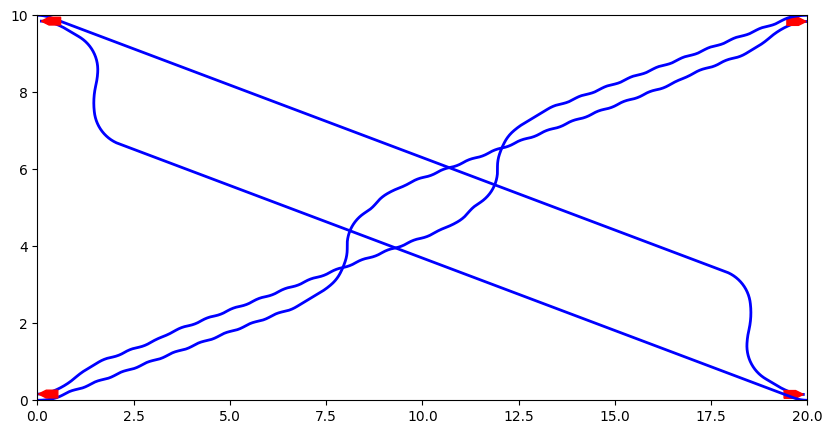

In [224]:
# Visualize

# Extract positions from the path for plotting
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlim(0, 20)
ax.set_ylim(0, 10)
ax.set_aspect('equal')

# plot_single_car_path(ax, path_1)
# plot_single_car_path(ax, path_2)
# plot_single_car_path(ax, path_3)
# plot_single_car_path(ax, path_4)
n = -1
for path in [path_1, path_2, path_3, path_4]:
    xs = [pos[0] for pos in path]
    ys = [pos[1] for pos in path]
    thetas = [pos[2] for pos in path]

    ax.plot(xs, ys, 'b-', linewidth=2)
    ax.arrow(xs[n]-0.5*cos(thetas[n]), ys[n]-0.5*sin(thetas[n]), 0.3*cos(thetas[n]), 0.3*sin(thetas[n]), head_width=0.2, head_length=0.2, width=0.2, fc='r', ec='r',zorder=2)


ax.plot()

In [230]:
distance(path_1[100],path_2[100])

9.440268216935904

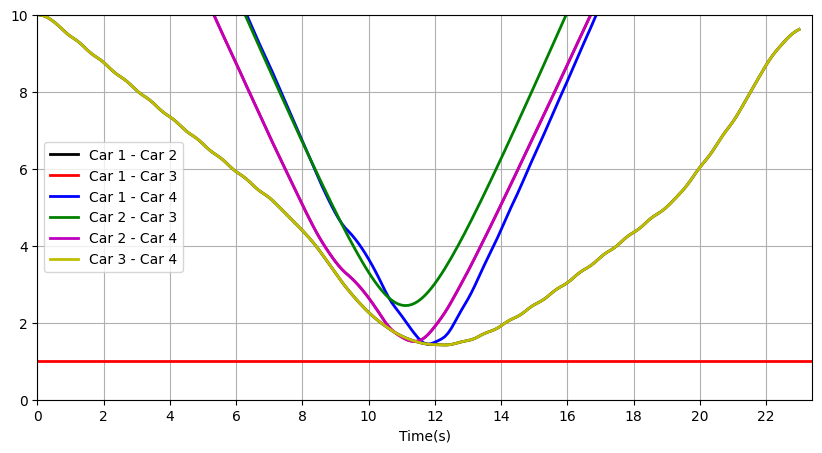

In [250]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlim(0, 2340)
ax.set_ylim(0, 10)

# Initialize lists to collect data points
x_points = list(range(0, 2304, 10))
y1_points = [distance(path_1[i], path_2[i]) for i in x_points]
y2_points = [distance(path_1[i], path_3[i]) for i in x_points]
y3_points = [distance(path_1[i], path_4[i]) for i in x_points]
y4_points = [distance(path_2[i], path_3[i]) for i in x_points]
y5_points = [distance(path_2[i], path_4[i]) for i in x_points]
y6_points = [distance(path_3[i], path_4[i]) for i in x_points]

# Plot the collected data points
ax.plot(x_points, y1_points, 'k-', linewidth=2,label='Car 1 - Car 2')
ax.plot(x_points, y2_points, 'r-', linewidth=2, label='Car 1 - Car 3')
ax.plot(x_points, y3_points, 'b-', linewidth=2, label='Car 1 - Car 4')
ax.plot(x_points, y4_points, 'g-', linewidth=2, label='Car 2 - Car 3')
ax.plot(x_points, y5_points, 'm-', linewidth=2, label='Car 2 - Car 4')
ax.plot(x_points, y6_points, 'y-', linewidth=2, label='Car 3 - Car 4')

ax.axhline(y=1, color='red', linewidth=2)

# Add labels and title
ax.set_xlabel('Time (s)')
xticks = [i for i in range(0, 2304, 200)]
ax.set_xticks(xticks)
ax.set_xticklabels([str(i // 100) for i in xticks])
ax.legend()
ax.grid()

plt.show()

In [225]:
def collision(p1, p2):
  return (p2[0]-p1[0])**2 + (p2[1]-p1[1])**2 < 1

def check_path_collision(paths):
  path_1, path_2, path_3, path_4 = paths
  print('path length' + str(len(path_1)) + str(len(path_2)) + str(len(path_3)) + str(len(path_4)))

  if path_1 and path_2 and path_3 and path_4:
    min_length  = min(len(path_1),len(path_2),len(path_3),len(path_4))
    for i in range(min_length):
      if collision(path_1[i], path_2[i]):
        return (path_1[i],path_2[i],i,1,2)
      if collision(path_1[i], path_3[i]):
        return (path_1[i],path_3[i],i,1,3)
      if collision(path_1[i], path_4[i]):
        return  (path_1[i],path_4[i],i,1,4)
      if collision(path_2[i], path_3[i]):
        return (path_2[i],path_3[i],i,2,3)
      if collision(path_2[i], path_4[i]):
        return (path_2[i],path_4[i],i,2,4)
      if collision(path_3[i], path_4[i]):
        return (path_3[i],path_4[i],i,3,4)
  return None

collision_check = check_path_collision([path_1, path_2, path_3, path_4])
print(collision_check)


path length2304234023402304
None


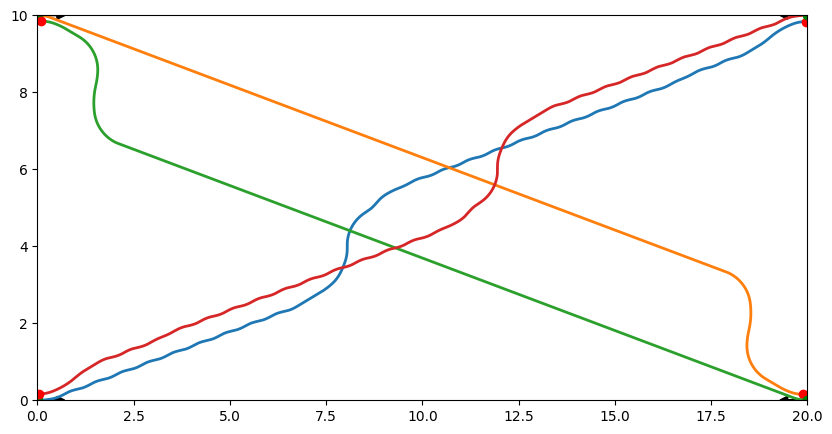

In [ ]:
# Animation
import matplotlib.animation as animation

def plot_multi_car_path(ax, paths):
    all_sampled_paths = []
    for path in paths:
        if path is None or not path:
            continue

        xs = [pos[0] for pos in path]
        ys = [pos[1] for pos in path]
        thetas = [pos[2] for pos in path]

        ax.plot(xs, ys, linewidth=2)
        ax.plot(xs[0], ys[0], 'go')  # Start point
        ax.plot(xs[-1], ys[-1], 'ro')  # End point

        # Sample 10 points for plotting direction arrows
        sample_indices = list(range(0, len(path), max(1, len(path) // 10)))
        sampled_path = [path[i] for i in sample_indices]

        all_sampled_paths.append(sampled_path)

    return all_sampled_paths

def update_arrows(num, ax, all_sampled_paths, all_arrows):
    for arrows in all_arrows:
        for arrow in arrows:
            arrow.remove()
        arrows.clear()

    for sampled_path in all_sampled_paths:
        x, y, theta = sampled_path[num]
        dx = cos(theta) * 0.5  # Arrow length
        dy = sin(theta) * 0.5
        arrow = ax.arrow(x, y, dx, dy, head_width=0.2, head_length=0.2, fc='k', ec='k')
        all_arrows.append(arrow)

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlim(0, 20)
ax.set_ylim(0, 10)
ax.set_aspect('equal')

paths = [path_1, path_2, path_3, path_4]
all_sampled_paths = plot_multi_car_path(ax, paths)
all_arrows = [[] for _ in paths]

# Create the animation
ani = animation.FuncAnimation(fig, update_arrows, frames=len(all_sampled_paths[0]),
                              fargs=(ax, all_sampled_paths, all_arrows), interval=500, repeat=True)


In [251]:
class CBSNode:
    def __init__(self, constraints=None, paths=None, cost=0):
        self.constraints = constraints if constraints else []
        self.paths = paths if paths else []
        self.cost = cost
    
    def __lt__(self, other):
        return self.cost < other.cost

In [ ]:
def generate_constraints(conflict):
    constraints = []
    x, y, time, agent1, agent2 = conflict[0], conflict[2], conflict[3], conflict[4]
    constraints.append((agent1, x, y))
    constraints.append((agent2, x, y))
    return constraints

def cbs():
    root = CBSNode()
    root.paths, root.cost = multi_car_hybrid_astar()
    open_set = []
    heapq.heappush(open_set, root)

    while open_set:
        node = heapq.heappop(open_set)
        conflict = check_path_collision(node.paths)
        
        if not conflict:
            return node.paths, node.cost

        constraints = generate_constraints(conflict)

        for constraint in constraints:
            new_constraints = node.constraints + [constraint]
            new_node = CBSNode(constraints=new_constraints)
            new_node.paths, new_node.cost = multi_car_hybrid_astar(conflicts=new_constraints)
            heapq.heappush(open_set, new_node)

    return None